In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import pandas as pd
from numba import jit

fittedPCR = pd.read_csv('~/Documents/Github/pcr-profile/PCR_curve_summary.csv')
fittedLFD = pd.read_csv('~/Documents/Github/pcr-profile/LFT_curve_summary.csv')
t = fittedPCR['days_since_infection'].to_numpy()
PCRpos = fittedPCR['median'].to_numpy()
LFDpos = fittedLFD['median'].to_numpy()
symponset = 4.84
dt = t[1]-t[0]
idt = 1/dt  #compute inverse to save time

In [2]:
def infectivity_profile():
    imean = 5.0
    istd = 1.92
    kguess = (istd/imean)**(-1.086)
    cguess = imean / sp.special.gamma(1 + 1/kguess)
    f = stats.weibull_min.pdf(t, kguess, scale=cguess)
    return f

def symp_profile():
    alpha = 4.84**2/2.8**2
    beta = 4.84/2.8**2
    g = stats.gamma.pdf(t, alpha, scale=1/beta)
    return g

iprof = infectivity_profile()
ggen = symp_profile()

In [3]:
@jit(nopython=True)
def infectivity_scale(ts, tt, td, tpos, Psisol, tisol, \
                      PLeaveEarly, PLeaveEarlyDelay):
    #calculate relative infectiousness given:
    #symptom onset ts
    #test times tt
    #test delays td
    #test positive probabilities tpos
    #Probability of symptom isolation Psisol
    #Duration of isolation tisol
    #PLeaveEarly: Probability for each test that, given a positive result, they subsequently get a -ve PCR
    #PLeaveEarlyDelay: Delay between LFD result and confirmatory PCR
    
    t_result = tt + td                      #time of result 
    t_result = np.append(t_result, ts)      #add symptom onset time (same effect a test result)
    t_order = np.argsort(t_result)      #sort into order results occur 
    t_prob = np.append(tpos, Psisol)    #add symptom isol prob (same effect a test result)
    p_leave_early = np.append(PLeaveEarly, 0.0)   #cannot leave isolation if symptomatic
    p_leave_early_delay = np.append(PLeaveEarlyDelay, 0.0)
    
    #sort in time order
    t_result = t_result[t_order]
    t_prob = t_prob[t_order]
    p_leave_early = p_leave_early[t_order]
    p_leave_early_delay = p_leave_early_delay[t_order]
    
    f_scale = np.ones(len(t))
    Pmissed = 1  #probability of no isolations so far
    for k in np.arange(len(t_result)):
        Ph = t_prob[k]*Pmissed       #probability of positive test
        trange = ((t >= t_result[k]) & (t < t_result[k] + tisol))   #isolation window if +ve
        trange2 = ((t >= t_result[k] + p_leave_early_delay[k]) & \
                   (t < t_result[k] + tisol))      #leave isolation window if conf PCR -ve  
        f_scale[trange] -= Ph          #subtract Ph for isol duration
        f_scale[trange2] += Ph*p_leave_early[k]      #add back on for leaving early fraction
        Pmissed *= (1 - t_prob[k]*(1 - p_leave_early[k]))     #if -ve testing continues, otherwise stops
    return f_scale

def infectivity_scale_no_test(ts, Psisol, tisol):
    #equivalent scaling with symptom isolation only (no testing)
    f_scale = np.ones(len(t))
    trange = (t >= ts) & (t < ts + tisol)
    f_scale[trange] -= Psisol

    return f_scale

def protocol_1(tsh, t0h, tauLFD, LFDadherence, td_PCR, Ps_isol, tisol,
               PCRconf = 0):
    #status quo: 2 LFDs a week with 1 concurrent PCR
#LFD test times
    ttLFD = np.arange(t0h, np.max(t), tauLFD)
    #time index of LFD test times
    ittLFD = np.array(np.round(ttLFD*idt),dtype=np.int)
    #PCR test times (if first is on t0)
    ttPCR1 = np.arange(t0h+dt, np.max(t), 7.0)
    ittPCR1 = np.array(np.round(ttPCR1*idt),dtype=np.int)
    #PCR test times (if first is on t1)
    #add dt increment so it occurs after LFD (and only if LFD is -ve
    #because LFD +ve results in confirmatory PCR anyway)
    ttPCR2 = np.arange(t0h+tauLFD+dt, np.max(t), 7.0)
    ittPCR2 = np.array(np.round(ttPCR2*idt),dtype=np.int)
    #test positive probabilites
    LFDtpos = LFDpos[ittLFD]*LFDadherence
    PCR1tpos = PCRpos[ittPCR1]
    PCR2tpos = PCRpos[ittPCR2]

    #all test times
    tt1 = np.concatenate((ttLFD,ttPCR1))
    tt2 = np.concatenate((ttLFD,ttPCR2))
    #all test probabilities
    tpos1 = np.concatenate((LFDtpos,PCR1tpos))
    tpos2 = np.concatenate((LFDtpos,PCR2tpos))
    #all test delays
    td1 = np.concatenate((np.zeros(len(ttLFD)),td_PCR*np.ones(len(ttPCR1))))
    td2 = np.concatenate((np.zeros(len(ttLFD)),td_PCR*np.ones(len(ttPCR2))))
    #all conf test -ve probabilities
    if PCRconf > 0:   #probability for confirmatory PCR different
        PLE1  = np.concatenate((1-PCRconf*np.ones(len(ttLFD)),
                                np.zeros(len(ttPCR1))))
        PLE2  = np.concatenate((1-PCRconf*np.ones(len(ttLFD)),
                                np.zeros(len(ttPCR2))))
    else:
        PLE1  = np.concatenate((1-PCRpos[ittLFD],np.zeros(len(ttPCR1))))
        PLE2  = np.concatenate((1-PCRpos[ittLFD],np.zeros(len(ttPCR2))))
    #all conf test delays
    PLED1 = td_PCR*np.ones(len(ttLFD) + len(ttPCR1))
    PLED2 = td_PCR*np.ones(len(ttLFD) + len(ttPCR2))
    #all these will get sorted inside the following functions
    fscale1 = infectivity_scale(tsh, tt1, td1, tpos1, Ps_isol, tisol, PLE1, PLED1)
    fscale2 = infectivity_scale(tsh, tt2, td2,tpos2, Ps_isol, tisol, PLE2, PLED2)
    
    return 0.5*(fscale1 + fscale2)

def protocol_2(tsh, t0h, tauLFD, LFDadherence, td_PCR, Ps_isol, tisol,
              PCRconf = 0):
    ttLFD = np.arange(t0h, np.max(t), tauLFD)
    ittLFD = np.array(np.round(ttLFD*idt),dtype=np.int)
    LFDtpos = LFDpos[ittLFD]*LFDadherence
    if PCRconf > 0:   #probability for confirmatory PCR different
        PLE = 1-PCRconf*np.ones(len(ttLFD))
    else:
        PLE = 1-PCRpos[ittLFD]
    PLED = td_PCR*np.ones(len(ttLFD))
    fscale = infectivity_scale(tsh, ttLFD, np.zeros(len(ttLFD)),\
                            LFDtpos, Ps_isol, tisol, PLE, PLED)
    return fscale

def protocol_3(tsh, t0Lh, tauLFD, LFDadherence, td_PCR, Ps_isol, tisol, 
               t0PCR, dt0PCR, idtPCR, PCRconf = 0):
    ttL = np.arange(t0Lh, np.max(t), tauLFD)
    ittL = np.array(np.round(ttL*idt),dtype=np.int)
    LFDtpos = LFDpos[ittL]*LFDadherence
    tdLFD = np.zeros(len(ttL))
    fint = np.zeros((len(t0PCR),len(t)))
    for k in np.arange(len(t0PCR)):  #need to integrate over all possible PCR first test times
        t0Ph = t0PCR[k]
        ttP = np.arange(t0Ph, np.max(t)-td_PCR, 14.0)
        ittP = np.array(np.round(ttP*idt),dtype=np.int)
        PCRtpos = PCRpos[ittP]
        tdPCR = td_PCR*np.ones(len(ttP))
        all_tests = np.concatenate((ttL,ttP))
        all_Pos = np.concatenate((LFDtpos,PCRtpos))
        all_delays = np.concatenate((tdLFD,tdPCR))
        if PCRconf > 0:
            PLeaveEarly = np.concatenate((1-PCRconf*np.ones(len(ttL)),
                                          np.zeros(len(ttP))))
        else:
            PLeaveEarly = np.concatenate((1-PCRpos[ittL],np.zeros(len(ttP))))    #probability +ve is not confirmed by PCR 
        PLeaveEarlyDelay = td_PCR*np.ones(len(ttP) + len(ttL))
        fint[k,:] = infectivity_scale(tsh, all_tests, all_delays, \
                                   all_Pos, Ps_isol, tisol, PLeaveEarly,
                                   PLeaveEarlyDelay)
    fscaleint = np.trapz(fint, t0PCR, axis=0)/(np.max(t0PCR) - np.min(t0PCR))   #integrate over PCR start time
    return fscaleint

def protocol_3a(tsh, t0h, tauLFD, LFDadherence, td_PCR, Ps_isol, 
                tisol, PCRconf = 0):
    #2 LFDs a week with 1 fortnightly concurrent PCR
    #this really needs tidying up now
    #LFD test times
    ttLFD = np.arange(t0h, np.max(t), tauLFD)
    #time index of LFD test times
    ittLFD = np.array(np.round(ttLFD*idt),dtype=np.int)
    #PCR test times (if first is on t0)
    ttPCR1 = np.arange(t0h+dt, np.max(t), 14.0)
    ittPCR1 = np.array(np.round(ttPCR1*idt),dtype=np.int)
    #PCR test times (if first is on t1)
    ttPCR2 = np.arange(t0h+tauLFD+dt, np.max(t), 14.0)
    ittPCR2 = np.array(np.round(ttPCR2*idt),dtype=np.int)
    #PCR test times (if first is on t2)
    ttPCR3 = np.arange(t0h+2*tauLFD+dt, np.max(t), 14.0)
    ittPCR3 = np.array(np.round(ttPCR3*idt),dtype=np.int)
    #PCR test times (if first is on t4)
    ttPCR4 = np.arange(t0h+3*tauLFD+dt, np.max(t), 14.0)
    ittPCR4 = np.array(np.round(ttPCR4*idt),dtype=np.int)
    #test positive probabilites
    LFDtpos = LFDpos[ittLFD]*LFDadherence
    PCR1tpos = PCRpos[ittPCR1]
    PCR2tpos = PCRpos[ittPCR2]
    PCR3tpos = PCRpos[ittPCR3]
    PCR4tpos = PCRpos[ittPCR4]

    #all test times
    tt1 = np.concatenate((ttLFD,ttPCR1))
    tt2 = np.concatenate((ttLFD,ttPCR2))
    tt3 = np.concatenate((ttLFD,ttPCR3))
    tt4 = np.concatenate((ttLFD,ttPCR4))
    #all test probabilities
    tpos1 = np.concatenate((LFDtpos,PCR1tpos))
    tpos2 = np.concatenate((LFDtpos,PCR2tpos))
    tpos3 = np.concatenate((LFDtpos,PCR3tpos))
    tpos4 = np.concatenate((LFDtpos,PCR4tpos))
    #all test delays
    td1 = np.concatenate((np.zeros(len(ttLFD)),td_PCR*np.ones(len(ttPCR1))))
    td2 = np.concatenate((np.zeros(len(ttLFD)),td_PCR*np.ones(len(ttPCR2))))
    td3 = np.concatenate((np.zeros(len(ttLFD)),td_PCR*np.ones(len(ttPCR3))))
    td4 = np.concatenate((np.zeros(len(ttLFD)),td_PCR*np.ones(len(ttPCR4))))
    #all conf test -ve probabilities
    if PCRconf > 0:
        Confp = 1 - PCRconf*np.ones(len(ttLFD))
        PLE1  = np.concatenate((Confp,np.zeros(len(ttPCR1))))
        PLE2  = np.concatenate((Confp,np.zeros(len(ttPCR2))))
        PLE3  = np.concatenate((Confp,np.zeros(len(ttPCR3))))
        PLE4  = np.concatenate((Confp,np.zeros(len(ttPCR4))))
    else:
        PLE1  = np.concatenate((1-PCRpos[ittLFD],np.zeros(len(ttPCR1))))
        PLE2  = np.concatenate((1-PCRpos[ittLFD],np.zeros(len(ttPCR2))))
        PLE3  = np.concatenate((1-PCRpos[ittLFD],np.zeros(len(ttPCR3))))
        PLE4  = np.concatenate((1-PCRpos[ittLFD],np.zeros(len(ttPCR4))))
    #all conf test delays
    PLED1 = td_PCR*np.ones(len(ttLFD) + len(ttPCR1))
    PLED2 = td_PCR*np.ones(len(ttLFD) + len(ttPCR2))
    PLED3 = td_PCR*np.ones(len(ttLFD) + len(ttPCR3))
    PLED4 = td_PCR*np.ones(len(ttLFD) + len(ttPCR4))
    #all these will get sorted inside the following functions
    fscale1 = infectivity_scale(tsh, tt1, td1, tpos1, Ps_isol, tisol, PLE1, PLED1)
    fscale2 = infectivity_scale(tsh, tt2, td2, tpos2, Ps_isol, tisol, PLE2, PLED2)
    fscale3 = infectivity_scale(tsh, tt3, td3, tpos3, Ps_isol, tisol, PLE3, PLED3)
    fscale4 = infectivity_scale(tsh, tt4, td4, tpos4, Ps_isol, tisol, PLE4, PLED4)
    
    return 0.25*(fscale1 + fscale2 + fscale3 + fscale4)

def integrate_protocol(protocol, td_PCR, Ps_isol, tisol, 
                       LFDadherence = 1.0, PCRconf = 0):
    
    gint = np.zeros(len(t))
    #set LFD test freq for each protocol
    if protocol == 2:
        tauLFD = 7.0/3.0   #3 times a week
    else:
        tauLFD = 3.5   #twice a week
        
    if protocol == 3:
        dt0PCR = 5*dt     
        #scaling this up to improve efficiency, but it reduces the calculation accuracy
        idtPCR = 1/dt0PCR
        t0PCR = np.append(np.arange(0, 14, dt0PCR),14)
    
    t0LFD = np.append(np.arange(0,tauLFD,dt),tauLFD)
    for i in np.arange(len(t)):    #loop over symptom onset
        tsh = t[i]         #symp onset
        fint = np.zeros(len(t0LFD))
        for j in np.arange(len(t0LFD)):    #loop over first LFD time
            t0h = t0LFD[j]
            if protocol == 0:  #no test
                fscale = infectivity_scale_no_test(tsh, Ps_isol, tisol)
            if protocol == 1:
                fscale = protocol_1(tsh, t0h, tauLFD, LFDadherence, td_PCR, Ps_isol, tisol, PCRconf)
            if protocol == 2:
                fscale = protocol_2(tsh, t0h, tauLFD, LFDadherence, td_PCR, Ps_isol, tisol, PCRconf)  
            if protocol == 3:
                fscale = protocol_3(tsh, t0h, tauLFD, LFDadherence, td_PCR, Ps_isol, tisol,\
                                    t0PCR, dt0PCR, idtPCR, PCRconf)     
            if protocol == 4:
                fscale = protocol_3a(tsh, t0h, tauLFD, LFDadherence, td_PCR, Ps_isol, tisol, PCRconf)   
            fh = iprof*fscale
            fint[j] = np.trapz(fh,t)

        gint[i] = np.trapz(fint,t0LFD)/tauLFD   #integrate over first LFD time
    F = np.trapz(ggen*gint,t)  #integrate over symptom onset
    
    return F



In [17]:
Ttype = ['(1)\nStatus Quo','(2)\n3 LFDs','(3a)\n2 LFDs + 14-day PCR','(3b)\n2 LFDs + Conc 14-day PCR']
tauisol = 10.0
tdPCR = [1.0, 2.0, 3.0]
PSisol = [0.0, 1.0]
Adherence = [0.0, 0.25, 0.5, 1.0]

In [5]:
Ftest_isol = np.zeros((len(PSisol),len(tdPCR),len(Adherence),4))
Fsymp_isol = np.zeros((len(PSisol)))
for i in np.arange(len(PSisol)):
    Fsymp_isol[i] = integrate_protocol(0, 0, PSisol[i], tauisol)
    for j in np.arange(len(tdPCR)):
        for k in np.arange(len(Adherence)):
            for m in np.arange(1,5):
                Ftest_isol[i,j,k,m-1] = integrate_protocol(m, tdPCR[j], \
                                                           PSisol[i], tauisol, Adherence[k])
                print('Done %d %d %d %d'%(i,j,k,m))
        

Done 0 0 0 1
Done 0 0 0 2
Done 0 0 0 3
Done 0 0 0 4
Done 0 0 1 1
Done 0 0 1 2
Done 0 0 1 3
Done 0 0 1 4
Done 0 0 2 1
Done 0 0 2 2
Done 0 0 2 3
Done 0 0 2 4
Done 0 0 3 1
Done 0 0 3 2
Done 0 0 3 3
Done 0 0 3 4
Done 0 1 0 1
Done 0 1 0 2
Done 0 1 0 3
Done 0 1 0 4
Done 0 1 1 1
Done 0 1 1 2
Done 0 1 1 3
Done 0 1 1 4
Done 0 1 2 1
Done 0 1 2 2
Done 0 1 2 3
Done 0 1 2 4
Done 0 1 3 1
Done 0 1 3 2
Done 0 1 3 3
Done 0 1 3 4
Done 0 2 0 1
Done 0 2 0 2
Done 0 2 0 3
Done 0 2 0 4
Done 0 2 1 1
Done 0 2 1 2
Done 0 2 1 3
Done 0 2 1 4
Done 0 2 2 1
Done 0 2 2 2
Done 0 2 2 3
Done 0 2 2 4
Done 0 2 3 1
Done 0 2 3 2
Done 0 2 3 3
Done 0 2 3 4
Done 1 0 0 1
Done 1 0 0 2
Done 1 0 0 3
Done 1 0 0 4
Done 1 0 1 1
Done 1 0 1 2
Done 1 0 1 3
Done 1 0 1 4
Done 1 0 2 1
Done 1 0 2 2
Done 1 0 2 3
Done 1 0 2 4
Done 1 0 3 1
Done 1 0 3 2
Done 1 0 3 3
Done 1 0 3 4
Done 1 1 0 1
Done 1 1 0 2
Done 1 1 0 3
Done 1 1 0 4
Done 1 1 1 1
Done 1 1 1 2
Done 1 1 1 3
Done 1 1 1 4
Done 1 1 2 1
Done 1 1 2 2
Done 1 1 2 3
Done 1 1 2 4
Done 1 1 3 1

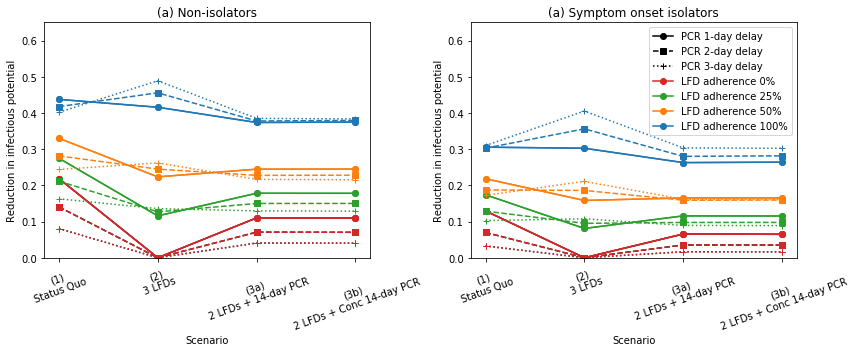

In [44]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
titles = ['(a)','(b)']
for i in [0,1]:
    tdstyles = ['o-','s--','+:']
    for j in np.arange(len(tdPCR)):
        ax[i].plot(Ttype, 1.0 - (Ftest_isol[i,j,0,:]/Fsymp_isol[i]), tdstyles[j],\
           label="PCR %d-day delay"%tdPCR[j], c='k')
          
    for k in np.arange(len(Adherence)):
        ax[i].plot(Ttype, 1.0 - (Ftest_isol[i,0,k,:]/Fsymp_isol[i]), tdstyles[0],\
               label='LFD adherence %d'%(100*Adherence[k])+"%", c='C%d'%(len(Adherence)-1-k))
    
            
    for j in np.arange(len(tdPCR)):            
        for k in np.arange(len(Adherence)):
            ax[i].plot(Ttype, 1.0 - (Ftest_isol[i,j,k,:]/Fsymp_isol[i]), tdstyles[j],\
                       c='C%d'%(len(Adherence)-1-k))
    ax[i].set_ylim(0,0.65)
    ax[i].tick_params(axis='x', labelrotation=20)
    ax[i].set_xlabel('Scenario')
    ax[i].set_ylabel('Reduction in infectious potential')
ax[1].legend()
ax[0].set_title('(a) Non-isolators')
ax[1].set_title('(a) Symptom onset isolators')
fig.tight_layout()
fig.savefig('scenario_v1.png')

Repeat but confirmatory PCR has 95% sensitivity

In [15]:
Ftest_isol2 = np.zeros((len(PSisol),len(tdPCR),len(Adherence),4))
Fsymp_isol2 = np.zeros((len(PSisol)))
for i in np.arange(len(PSisol)):
    for j in np.arange(len(tdPCR)):
        for k in np.arange(len(Adherence)):
            for m in np.arange(1,5):
                Ftest_isol2[i,j,k,m-1] = integrate_protocol(m, tdPCR[j], \
                                       PSisol[i], tauisol, Adherence[k],0.95)
                print('Done %d %d %d %d'%(i,j,k,m))

Done 0 0 0 1
Done 0 0 0 2
Done 0 0 0 3
Done 0 0 0 4
Done 0 0 1 1
Done 0 0 1 2
Done 0 0 1 3
Done 0 0 1 4
Done 0 0 2 1
Done 0 0 2 2
Done 0 0 2 3
Done 0 0 2 4
Done 0 0 3 1
Done 0 0 3 2
Done 0 0 3 3
Done 0 0 3 4
Done 0 1 0 1
Done 0 1 0 2
Done 0 1 0 3
Done 0 1 0 4
Done 0 1 1 1
Done 0 1 1 2
Done 0 1 1 3
Done 0 1 1 4
Done 0 1 2 1
Done 0 1 2 2
Done 0 1 2 3
Done 0 1 2 4
Done 0 1 3 1
Done 0 1 3 2
Done 0 1 3 3
Done 0 1 3 4
Done 0 2 0 1
Done 0 2 0 2
Done 0 2 0 3
Done 0 2 0 4
Done 0 2 1 1
Done 0 2 1 2
Done 0 2 1 3
Done 0 2 1 4
Done 0 2 2 1
Done 0 2 2 2
Done 0 2 2 3
Done 0 2 2 4
Done 0 2 3 1
Done 0 2 3 2
Done 0 2 3 3
Done 0 2 3 4
Done 1 0 0 1
Done 1 0 0 2
Done 1 0 0 3
Done 1 0 0 4
Done 1 0 1 1
Done 1 0 1 2
Done 1 0 1 3
Done 1 0 1 4
Done 1 0 2 1
Done 1 0 2 2
Done 1 0 2 3
Done 1 0 2 4
Done 1 0 3 1
Done 1 0 3 2
Done 1 0 3 3
Done 1 0 3 4
Done 1 1 0 1
Done 1 1 0 2
Done 1 1 0 3
Done 1 1 0 4
Done 1 1 1 1
Done 1 1 1 2
Done 1 1 1 3
Done 1 1 1 4
Done 1 1 2 1
Done 1 1 2 2
Done 1 1 2 3
Done 1 1 2 4
Done 1 1 3 1

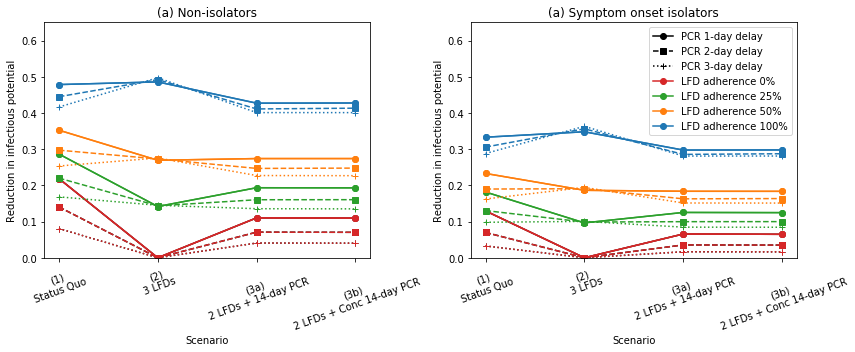

In [43]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
titles = ['(a)','(b)']
for i in [0,1]:
    tdstyles = ['o-','s--','+:']
    for j in np.arange(len(tdPCR)):
        ax[i].plot(Ttype, 1.0 - (Ftest_isol2[i,j,0,:]/Fsymp_isol[i]), tdstyles[j],\
           label="PCR %d-day delay"%tdPCR[j], c='k')
          
    for k in np.arange(len(Adherence)):
        ax[i].plot(Ttype, 1.0 - (Ftest_isol2[i,0,k,:]/Fsymp_isol[i]), tdstyles[0],\
               label='LFD adherence %d'%(100*Adherence[k])+"%", c='C%d'%(len(Adherence)-1-k))
    
            
    for j in np.arange(len(tdPCR)):            
        for k in np.arange(len(Adherence)):
            ax[i].plot(Ttype, 1.0 - (Ftest_isol2[i,j,k,:]/Fsymp_isol[i]), tdstyles[j],\
                       c='C%d'%(len(Adherence)-1-k))
    ax[i].set_ylim(0,0.65)
    ax[i].tick_params(axis='x', labelrotation=20)
    ax[i].set_xlabel('Scenario')
    ax[i].set_ylabel('Reduction in infectious potential')
ax[1].legend()
ax[0].set_title('(a) Non-isolators')
ax[1].set_title('(a) Symptom onset isolators')
fig.tight_layout()
fig.savefig('scenario_v2.png')

1.059610821131102 1.0572007524813605
[1.06818849 1.03249567] [1.06076335 1.02918303]


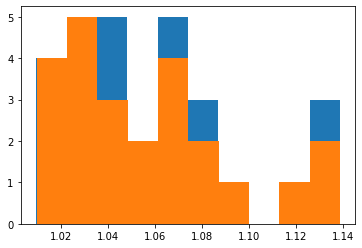

In [42]:
# Results = {"PSisol": , "PSisoldim": 0, "PCRconf1": Ftest_isol, 
scen2_rela = Ftest_isol[:,:,:,2]/Ftest_isol[:,:,:,0]
scen2_relb = Ftest_isol2[:,:,:,2]/Ftest_isol2[:,:,:,0]
plt.hist(scen2_rela.flatten())
plt.hist(scen2_relb.flatten())
print(np.mean(scen2_rela), np.mean(scen2_relb))
print(scen2_rela[:,1,3],scen2_relb[:,1,3])
           
           
# scen2_rela = Ftest_isol[:,:,:,2] -Ftest_isol[:,:,:,0]
# scen2_rela[0,:,:] = scen2_rela[0,:,:]/Fsymp_isol[0]
# scen2_rela[1,:,:] = scen2_rela[1,:,:]/Fsymp_isol[1]
# scen2_relb = Ftest_isol2[:,:,:,2]-Ftest_isol2[:,:,:,0]
# scen2_relb[0,:,:] = scen2_relb[0,:,:]/Fsymp_isol[0]
# scen2_relb[1,:,:] = scen2_relb[1,:,:]/Fsymp_isol[1]
# plt.hist(scen2_rela.flatten())
# plt.hist(scen2_relb.flatten())
# print(np.mean(scen2_rela), np.mean(scen2_relb))

Debugging zone

In [ ]:
plt.plot(t,PCRpos,label='PCR')
plt.plot(t,LFDpos,label='LFD')
plt.xlabel('Test Date (days since infection)')
plt.ylabel('Test positive probability')
plt.legend()
plt.xlim(0,14)
plt.ylim(0,1.0)
plt.savefig('test_pos_profiles.png')

In [ ]:
plt.plot(t,ggen,label='Symptom onset time')
plt.plot(t,iprof,label='Infectiousness')
plt.xlabel('Time (days since infection)')
plt.ylabel('Probability distribution function')
plt.xlim(0,14)
plt.ylim(0,0.21)
plt.legend()
plt.savefig('symp_and_inf.png')

In [ ]:
#checking protocol 1 makes sense
tsh = 4.8
t0h = 2.0
Ps_isol = 0.6
tisol=10
td_PCR=1
tauLFD=3.5
fscale = protocol_1(tsh, t0h, tauLFD, 1.0, td_PCR, Ps_isol, tisol)
fscale_alt = protocol_1(tsh, t0h, tauLFD, 1.0, td_PCR, Ps_isol, tisol, 0.95)
fscale0 = infectivity_scale_no_test(tsh, Ps_isol, tisol)
#plt.plot(t,iprof)
plt.plot(t,fscale0)
plt.plot(t,fscale)
plt.plot(t,fscale_alt)
plt.xlim(0,11)

(0, 11)

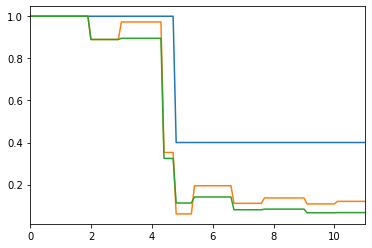

In [20]:
#checking protocol 2 makes sense
tsh = 4.8
t0h = 2.0
Ps_isol = 0.6
tisol=10
td_PCR=1
tauLFD=7.0/3.0
fscale = protocol_2(tsh, t0h, tauLFD, 1.0, td_PCR, Ps_isol, tisol)
fscale_alt = protocol_2(tsh, t0h, tauLFD, 1.0, td_PCR, Ps_isol, tisol, 0.95)
fscale0 = infectivity_scale_no_test(tsh, Ps_isol, tisol)
#plt.plot(t,iprof)
plt.plot(t,fscale0)
plt.plot(t,fscale)
plt.plot(t,fscale_alt)
plt.xlim(0,11)

(0, 11)

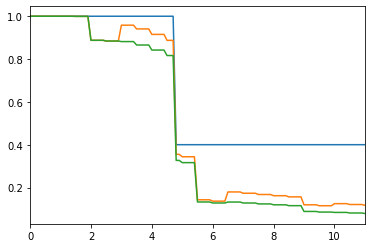

In [21]:
#checking protocol 3 makes sense
dtPCR0 = dt*5
idtPCR = 1/dtPCR0
t0PCR = np.arange(0, 14, dtPCR0)

tsh = 4.8
t0h = 2.0
Ps_isol = 0.6
tisol=10
td_PCR=1
tauLFD=3.5
fscale = protocol_3(tsh, t0h, tauLFD, 1.0, td_PCR, Ps_isol, tisol, t0PCR, dtPCR0, idtPCR)
fscale_alt = protocol_3(tsh, t0h, tauLFD, 1.0, td_PCR, Ps_isol, tisol, t0PCR, dtPCR0, idtPCR, 0.95)
fscale0 = infectivity_scale_no_test(tsh, Ps_isol, tisol)
#plt.plot(t,iprof)
plt.plot(t,fscale0)
plt.plot(t,fscale)
plt.plot(t,fscale_alt)
plt.xlim(0,11)

(0, 11)

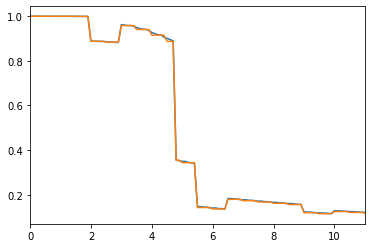

In [22]:
#check protocol 3 against dt = 0.1 (i.e integration error)
dtPCR0 = dt
idtPCR = 1/dtPCR0
t0PCR = np.arange(0, 14, dtPCR0)

tsh = 4.8
t0h = 2.0
Ps_isol = 0.6
tisol=10
td_PCR=1
tauLFD=3.5
fscalecorr = protocol_3(tsh, t0h, tauLFD, 1.0, td_PCR, Ps_isol, tisol, t0PCR, dtPCR0, idtPCR)
#plt.plot(t,iprof)
plt.plot(t,fscalecorr)
plt.plot(t,fscale)
plt.xlim(0,11)

(0, 14)

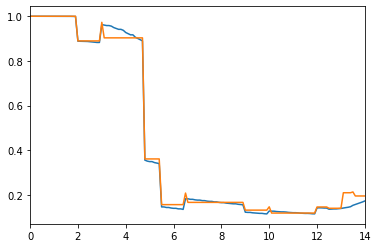

In [23]:
#check protocol 3 against 3a
tsh = 4.8
t0h = 2.0
Ps_isol = 0.6
tisol=10
td_PCR=1
tauLFD=3.5
fscale3a = protocol_3a(tsh, t0h, tauLFD, 1.0, td_PCR, Ps_isol, tisol)
#plt.plot(t,iprof)
plt.plot(t,fscalecorr)
plt.plot(t,fscale3a)
plt.xlim(0,14)

In [37]:
#test that scenario2 matches no test case when probabilities are 0
tsh = 8
t0h = 2.0
Ps_isol = 0.0
tisol=10
td_PCR=1
tauLFD=7.0/3.0
p2_result = integrate_protocol(2, td_PCR, Ps_isol, tisol, 0.0)
p0_result = integrate_protocol(0, td_PCR, Ps_isol, tisol, 0.0)
#plt.plot(t,iprof)
print(p0_result, p2_result, p2_result/p0_result)

0.9999980017129811 0.9999980017129814 1.0000000000000002


In [30]:
Ftest_isol[0,0,0,1]
Fsymp_isol[0]

0.9714266302354674